# NAME : İlker Efil

# Scrape enough data

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
# Function to scrape quotes
def scrape_quotes(base_url):
    quotes = []
    url = base_url
    while url:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        for quote in soup.select('.quote'):
            text = quote.select_one('.text').get_text(strip=True)
            tags = [tag.get_text(strip=True) for tag in quote.select('.tag')]
            quotes.append({'text': text, 'tags': tags})
        next_btn = soup.select_one('li.next > a')
        url = base_url + next_btn['href'] if next_btn else None
    return quotes

base_url = "http://quotes.toscrape.com/"
quotes_data = scrape_quotes(base_url)
df_quotes = pd.DataFrame(quotes_data)

In [3]:
df_quotes.head()

,text,tags
0,“The world as we have created it is a process ...,"[change, deep-thoughts, thinking, world]"
1,"“It is our choices, Harry, that show what we t...","[abilities, choices]"
2,“There are only two ways to live your life. On...,"[inspirational, life, live, miracle, miracles]"
3,"“The person, be it gentleman or lady, who has ...","[aliteracy, books, classic, humor]"
4,"“Imperfection is beauty, madness is genius and...","[be-yourself, inspirational]"


##### Data preprocessing

Selecting Possible Labels:

Analyze the frequency of tags and select the top 10 most frequent tags to ensure enough samples for reliable model training.

In [4]:
from collections import Counter

# Count frequency of each tag
all_tags = [tag for tags in df_quotes['tags'] for tag in tags]
top_10_tags = [tag for tag, _ in Counter(all_tags).most_common(10)]

# Filter quotes with top 10 tags
df_quotes['tags'] = df_quotes['tags'].apply(lambda tags: [tag for tag in tags if tag in top_10_tags])
df_quotes = df_quotes[df_quotes['tags'].map(len) > 0]

#  Convert text data into numeric data

- Bag of Words (BoW): This technique involves creating a matrix where each row represents a document and each column represents a unique word from the entire dataset, with cell values indicating the frequency of the word in the document.

- TF-IDF (Term Frequency-Inverse Document Frequency): Similar to BoW but gives more weight to words that are unique to a document by reducing the weight of words that frequently appear across all documents.

- Word Embeddings (e.g., Word2Vec, GloVe): These techniques convert words into dense vectors of fixed size, capturing semantic relationships between words.

Chosen Option and Rationale:

TF-IDF: This method balances the importance of common and unique words, providing a good compromise between the simplicity of BoW and the complexity of Word Embeddings. It is also computationally efficient and performs well for many text classification tasks.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df_quotes['text'])

# Convert the labels to a binary array
mlb = MultiLabelBinarizer(classes=top_10_tags)
y = mlb.fit_transform(df_quotes['tags'])

# Create a model

**Model Choice:**

Logistic Regression with OneVsRestClassifier: Chosen for its simplicity, interpretability, and effectiveness in multi-label classification.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
lr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
lr_model.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

# Train your model

There are multiple ways to train and optimize a model:

- Basic Training: The simplest way to train the model is by fitting it directly on the training data. This involves setting basic parameters like maximum iterations.

- Cross-Validation: Cross-validation helps in assessing the model's performance by splitting the data into different subsets and ensuring the model generalizes well to unseen data.


- Hyperparameter Tuning: Hyperparameter tuning involves adjusting parameters to optimize model performance. This can be done using GridSearchCV or RandomizedSearchCV.

Parameters to Tune:

C: Inverse of regularization strength.

max_iter: Maximum number of iterations for convergence.

In [7]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Logistic Regression
param_grid_lr = {
    'estimator__C': [0.1, 1, 10],
    'estimator__max_iter': [100, 300, 1000]
}

# GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(OneVsRestClassifier(LogisticRegression(random_state=42)), param_grid_lr, cv=5, n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train)
best_lr_model = grid_search_lr.best_estimator_
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for Logistic Regression: {'estimator__C': 0.1, 'estimator__max_iter': 100}


# Evaluate your model

C:\Users\ilker\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilker\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilker\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

         love       0.00      0.00      0.00         2
inspirational       0.00      0.00      0.00         3
         life       0.00      0.00      0.00         4
        humor       0.00      0.00      0.00         4
        books       0.00      0.00      0.00         1
      reading       0.00      0.00      0.00         1
   friendship       0.00      0.00      0.00         1
      friends       0.00      0.00      0.00         1
        truth       0.00      0.00      0.00         1
       simile       0.00      0.00      0.00         1

    micro avg       0.00      0.00      0.00        19
    macro avg       0.00      0.00      0.00        19
 weighted avg       0.00      0.00      0.00        19
  samples avg       0.00      0.00      0.00        19



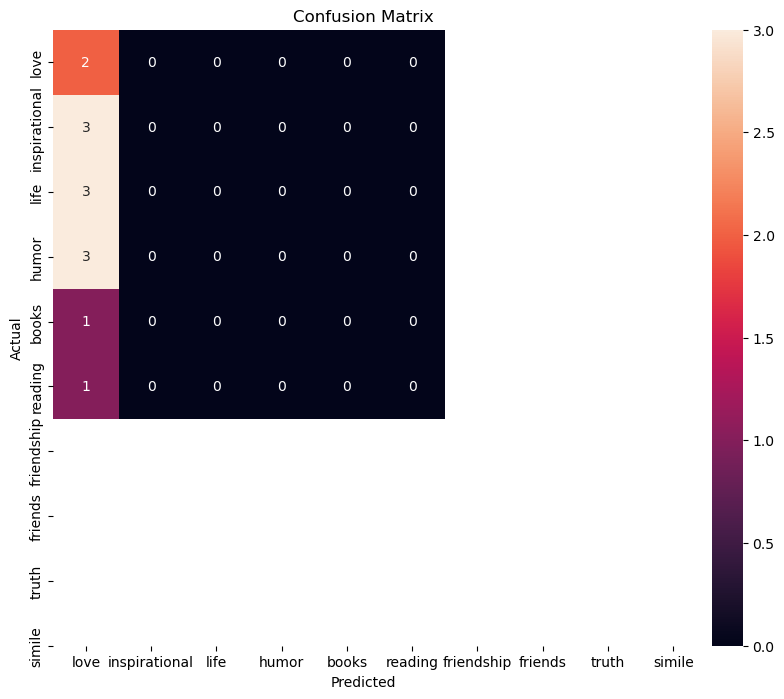

In [8]:
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Make predictions
y_pred = best_lr_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

# Confusion matrix
conf_mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

---------------

---------------

---------------

### Learning Curve

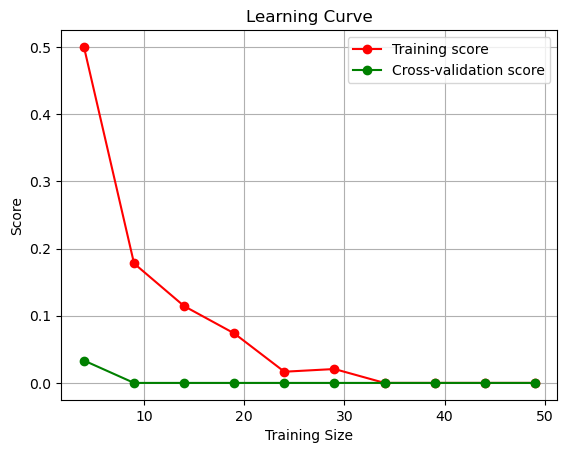

In [9]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.xlabel('Training Size')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.title('Learning Curve')
    plt.grid()
    plt.show()

# Using the RandomForestClassifier with OneVsRest strategy
plot_learning_curve(OneVsRestClassifier(LogisticRegression(random_state=42)), X_tfidf, y)

**The graph shows that both the training and cross-validation scores are low, and there isn't any significant improvement as the training size increases. This suggests that the model is not learning well due to the lack of sufficient data.**

-------------

-------------

-------------

**What could you do better if you were given enough resources?**

More Data:
   - This would help the model learn better and be more accurate.
   
Better Models:
   - Deep learning models like BERT, GPT-3, or Transformer models which can understand context better and improve classification accuracy.

Improved Tuning:
   - More sophisticated methods to find the best model settings.

**What improvements can be made on the project?**

Real-Time Use:
   - API Development: Create an API for instant quote classification.
   - User Interface: Design an easy-to-use interface for the API.

Better Evaluation:
   - Custom Metrics: Develop metrics that better match the project needs.
   - Robust Evaluation: Use thorough testing methods to ensure reliability.

**Where could you use such a project?**

Sentiment Analysis Tools:
   - Improve tools that analyze text by adding topic classification for quotes.

Educational Platforms:
   - Help students and teachers find quotes by category for assignments and projects.

**Summary**

**Decisions:**

- **Data Source:** Quotes to Scrape
- **Preprocessing:** Focused on the top 10 tags and used TF-IDF to convert text to numbers.
- **Model Selection:** Used Logistic Regression with OneVsRestClassifier for multi-label classification.
- **Evaluation:** Used classification reports and confusion matrices to check performance.
- **Optimization:** Applied hyperparameter tuning to improve the model.

With more resources, the project can be enhanced by collecting more data, using advanced models, improving feature engineering, and leveraging better computing power. These steps would lead to a more accurate and user-friendly quote classification system suitable for various applications.